In [129]:
import os

import torch

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.face_detection import get_fair_face, get_utk
from source.utils.metrics import accuracy, aod, eod, spd

os.makedirs(PLOTS_PATH, exist_ok=True)

In [130]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

models = ["resnet18", "resnet34", "resnet50"]

targets = ["age", "gender", "race (old)", "race"]
# predicting race does not give high unfairness (with either pa) for eod and aod
# predicting gender also not too nice (only unfairness with age)
target = 0 # 0, 1, 2, 3
pa = 1 # 0, 1, 2, 3

In [131]:
# no need to define targets and protected attributes, are queried directly afterwards
ff_train_ds, ff_test_ds = get_fair_face(binarize=True, augment=False)
utk_test_ds = get_utk(binarize=True)

run_path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{models[0]}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds), len(ff_test_ds), len(utk_test_ds))

# get targets and protected attributes
y_fair_t = ff_train_ds.targets[target, fair_inds]
a_fair_t = ff_train_ds.targets[pa, fair_inds]
y_val_t = ff_train_ds.targets[target, val_inds]
a_val_t = ff_train_ds.targets[pa, val_inds]
y_ff_test_t = ff_test_ds.targets[target]
a_ff_test_t = ff_test_ds.targets[pa]
y_utk_test_t = utk_test_ds.targets[target]
a_utk_test_t = utk_test_ds.targets[pa]

10843 10843 10954 23705


### Analyze Distributions

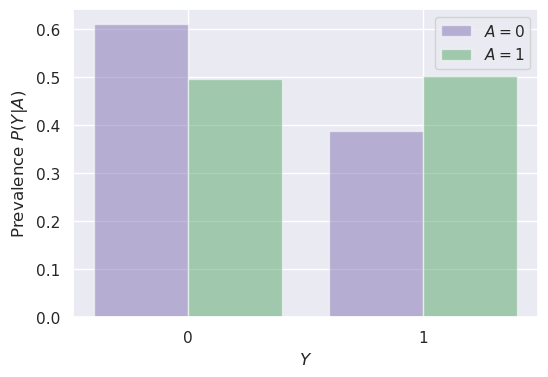

In [132]:
# plot p(Y | A) for fairface testset
p_y1_a0 = y_ff_test_t[a_ff_test_t == 0].float().mean().item()
p_y1_a1 = y_ff_test_t[a_ff_test_t == 1].float().mean().item()
p_y0_a0 = 1 - p_y1_a0
p_y0_a1 = 1 - p_y1_a1

# barplot
plt.figure(figsize=(6, 4))
plt.bar([-0.2, 0.8], [p_y0_a0, p_y1_a0], color="C4", width=0.4, alpha=0.5, label='$A=0$')
plt.bar([0.2, 1.2], [p_y0_a1, p_y1_a1], color="C2", width=0.4, alpha=0.5, label='$A=1$')
plt.xlabel('$Y$')
plt.ylabel('Prevalence $P(Y | A)$')
plt.xticks([0, 1])
plt.legend()
plt.show()

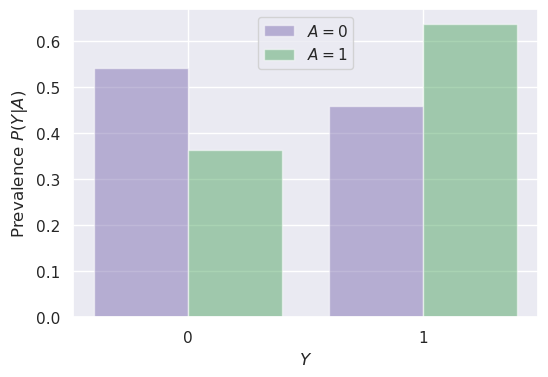

In [133]:
# plot p(Y | A) for utk testset
p_y1_a0 = y_utk_test_t[a_utk_test_t == 0].float().mean().item()
p_y1_a1 = y_utk_test_t[a_utk_test_t == 1].float().mean().item()
p_y0_a0 = 1 - p_y1_a0
p_y0_a1 = 1 - p_y1_a1

# barplot
plt.figure(figsize=(6, 4))
plt.bar([-0.2, 0.8], [p_y0_a0, p_y1_a0], color="C4", width=0.4, alpha=0.5, label='$A=0$')
plt.bar([0.2, 1.2], [p_y0_a1, p_y1_a1], color="C2", width=0.4, alpha=0.5, label='$A=1$')
plt.xlabel('$Y$')
plt.ylabel('Prevalence $P(Y | A)$')
plt.xticks([0, 1])
plt.legend()
plt.show()

In [134]:
# load probits
ff_test_probits, utk_test_probits = list(), list()

for model in models:
    fftp, utp = list(), list()
    for mseed in method_seeds:
        path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}")

        fftp.append(torch.load(os.path.join(path, f"ff_test_probits_t{target}.pt")))
        utp.append(torch.load(os.path.join(path, f"utk_test_probits_t{target}.pt")))
    
    ff_test_probits.append(torch.stack(fftp, dim=0))
    utk_test_probits.append(torch.stack(utp, dim=0))

ff_test_probits = torch.stack(ff_test_probits, dim=0)
utk_test_probits = torch.stack(utk_test_probits, dim=0)

print(ff_test_probits.shape, utk_test_probits.shape)

torch.Size([3, 5, 10, 10954, 2]) torch.Size([3, 5, 10, 23705, 2])


In [135]:
ff_test_m_accs, utk_test_m_accs = list(), list()
ff_test_m_spds, utk_test_m_spds = list(), list()
ff_test_m_eods, utk_test_m_eods = list(), list()
ff_test_m_aods, utk_test_m_aods = list(), list()

for m in range(len(models)):
    for s in range(len(method_seeds)):

        ff_test_m_accs.append(accuracy(torch.mean(ff_test_probits[m, s], dim=0).argmax(dim=1), y_ff_test_t) \
                                - torch.mean(torch.tensor([accuracy(ftp.argmax(dim=1), y_ff_test_t) for ftp in ff_test_probits[m, s]])))
        utk_test_m_accs.append(accuracy(torch.mean(utk_test_probits[m, s], dim=0).argmax(dim=1), y_utk_test_t) \
                                - torch.mean(torch.tensor([accuracy(utp.argmax(dim=1), y_utk_test_t) for utp in utk_test_probits[m, s]])))

        ff_test_m_spds.append(spd(torch.mean(ff_test_probits[m, s], dim=0).argmax(dim=1), a_ff_test_t) \
                              - torch.mean(torch.tensor([spd(ftp.argmax(dim=1), a_ff_test_t) for ftp in ff_test_probits[m, s]])))
        utk_test_m_spds.append(spd(torch.mean(utk_test_probits[m, s], dim=0).argmax(dim=1), a_utk_test_t) \
                                 - torch.mean(torch.tensor([spd(utp.argmax(dim=1), a_utk_test_t) for utp in utk_test_probits[m, s]])))
        
        ff_test_m_eods.append(eod(torch.mean(ff_test_probits[m, s], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t) \
                                - torch.mean(torch.tensor([eod(ftp.argmax(dim=1), y_ff_test_t, a_ff_test_t) for ftp in ff_test_probits[m, s]])))
        utk_test_m_eods.append(eod(torch.mean(utk_test_probits[m, s], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t) \
                                - torch.mean(torch.tensor([eod(utp.argmax(dim=1), y_utk_test_t, a_utk_test_t) for utp in utk_test_probits[m, s]])))
        
        ff_test_m_aods.append(aod(torch.mean(ff_test_probits[m, s], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t) \
                                - torch.mean(torch.tensor([aod(ftp.argmax(dim=1), y_ff_test_t, a_ff_test_t) for ftp in ff_test_probits[m, s]])))
        utk_test_m_aods.append(aod(torch.mean(utk_test_probits[m, s], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t) \
                                - torch.mean(torch.tensor([aod(utp.argmax(dim=1), y_utk_test_t, a_utk_test_t) for utp in utk_test_probits[m, s]])))

# reshape to (models, seeds)
ff_test_m_accs = torch.stack(ff_test_m_accs).reshape(len(models), len(method_seeds))
utk_test_m_accs = torch.stack(utk_test_m_accs).reshape(len(models), len(method_seeds))
ff_test_m_spds = torch.stack(ff_test_m_spds).reshape(len(models), len(method_seeds))
utk_test_m_spds = torch.stack(utk_test_m_spds).reshape(len(models), len(method_seeds))
ff_test_m_eods = torch.stack(ff_test_m_eods).reshape(len(models), len(method_seeds))
utk_test_m_eods = torch.stack(utk_test_m_eods).reshape(len(models), len(method_seeds))
ff_test_m_aods = torch.stack(ff_test_m_aods).reshape(len(models), len(method_seeds))
utk_test_m_aods = torch.stack(utk_test_m_aods).reshape(len(models), len(method_seeds))

print(ff_test_m_spds.shape, ff_test_m_spds.shape)

torch.Size([3, 5]) torch.Size([3, 5])


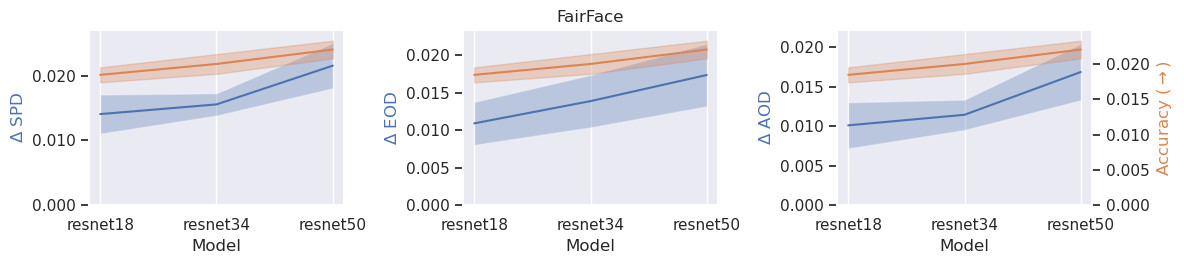

In [136]:
x = list(range(len(models)))
color = "C0"

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 2.8), sharex=True)

axs[0].plot(x, torch.mean(ff_test_m_spds, dim=1), "-")
axs[0].fill_between(x, 
                       torch.mean(ff_test_m_spds, dim=1) - torch.std(ff_test_m_spds, dim=1), 
                       torch.mean(ff_test_m_spds, dim=1) + torch.std(ff_test_m_spds, dim=1), alpha=0.3)
axs[0].set_ylabel("$\Delta$ SPD", color=color)
acc_axs.append(axs[0].twinx())
axs[1].plot(x, torch.mean(ff_test_m_eods, dim=1), "-")
axs[1].fill_between(x, 
                       torch.mean(ff_test_m_eods, dim=1) - torch.std(ff_test_m_eods, dim=1), 
                       torch.mean(ff_test_m_eods, dim=1) + torch.std(ff_test_m_eods, dim=1), alpha=0.3)
axs[1].set_ylabel("$\Delta$ EOD", color=color)
acc_axs.append(axs[1].twinx())
axs[2].plot(x, torch.mean(ff_test_m_aods, dim=1), "-")
axs[2].fill_between(x, 
                       torch.mean(ff_test_m_aods, dim=1) - torch.std(ff_test_m_aods, dim=1), 
                       torch.mean(ff_test_m_aods, dim=1) + torch.std(ff_test_m_aods, dim=1), alpha=0.3)
axs[2].set_ylabel("$\Delta$ AOD", color=color)
acc_axs.append(axs[2].twinx())

axs[1].set_title("FairFace")

for ax in acc_axs:
    ax.plot(x, torch.mean(ff_test_m_accs, dim=1), "-", c="C1")
    ax.fill_between(x, 
                    torch.mean(ff_test_m_accs, dim=1) - torch.std(ff_test_m_accs, dim=1), 
                    torch.mean(ff_test_m_accs, dim=1) + torch.std(ff_test_m_accs, dim=1), alpha=0.3, color="C1")

plot_negative = False
for constraint in (ff_test_m_spds, ff_test_m_eods, ff_test_m_aods):
    if torch.mean(constraint) - torch.std(constraint) < 0:
        plot_negative = True
        break

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xticks(x)
    ax.set_xlabel("Model")
    ax.set_xticklabels(models)

    y_lims = ax.get_ylim()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
    y_lim = max(abs(y_lims[0]), abs(y_lims[1]))
    if plot_negative:
        ax.set_ylim(-y_lim * (1 + ax.margins()[0]), y_lim * (1 + ax.margins()[1]))
        ax.hlines(0, 0, len(models) - 1, colors="black", linestyles="--", alpha=0.2)
    else:
        ax.set_ylim(0, y_lim * (1 + ax.margins()[1]))

for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])
    
    y_lims = ax.get_ylim()
    y_lim = max(abs(y_lims[0]), abs(y_lims[1]))
    if plot_negative:
        ax.set_ylim(-y_lim * (1 + ax.margins()[0]), y_lim * (1 + ax.margins()[1]))
        ax.hlines(0, 0, len(models) - 1, colors="black", linestyles="--", alpha=0.2)
    else:
        ax.set_ylim(0, y_lim * (1 + ax.margins()[1]))


f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"compare_models_target{target}_pa{pa}_ff.pdf"))
plt.show()

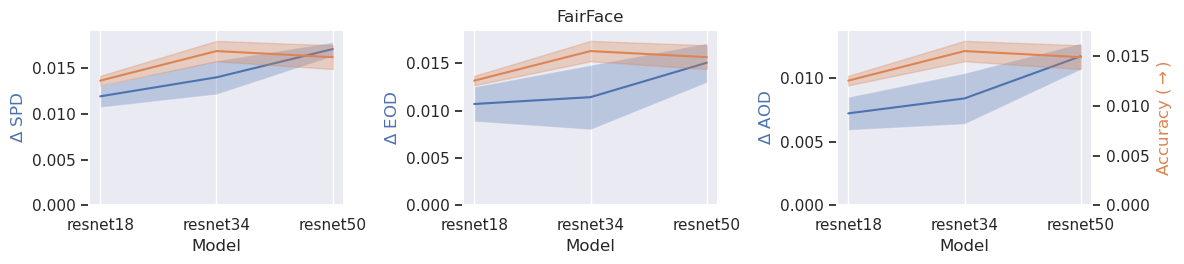

In [137]:
x = list(range(len(models)))
color = "C0"

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 2.8), sharex=True)

axs[0].plot(x, torch.mean(utk_test_m_spds, dim=1), "-")
axs[0].fill_between(x, 
                       torch.mean(utk_test_m_spds, dim=1) - torch.std(utk_test_m_spds, dim=1), 
                       torch.mean(utk_test_m_spds, dim=1) + torch.std(utk_test_m_spds, dim=1), alpha=0.3)
axs[0].set_ylabel("$\Delta$ SPD", color=color)
acc_axs.append(axs[0].twinx())
axs[1].plot(x, torch.mean(utk_test_m_eods, dim=1), "-")
axs[1].fill_between(x, 
                       torch.mean(utk_test_m_eods, dim=1) - torch.std(utk_test_m_eods, dim=1), 
                       torch.mean(utk_test_m_eods, dim=1) + torch.std(utk_test_m_eods, dim=1), alpha=0.3)
axs[1].set_ylabel("$\Delta$ EOD", color=color)
acc_axs.append(axs[1].twinx())
axs[2].plot(x, torch.mean(utk_test_m_aods, dim=1), "-")
axs[2].fill_between(x, 
                       torch.mean(utk_test_m_aods, dim=1) - torch.std(utk_test_m_aods, dim=1), 
                       torch.mean(utk_test_m_aods, dim=1) + torch.std(utk_test_m_aods, dim=1), alpha=0.3)
axs[2].set_ylabel("$\Delta$ AOD", color=color)
acc_axs.append(axs[2].twinx())

axs[1].set_title("FairFace")

for ax in acc_axs:
    ax.plot(x, torch.mean(utk_test_m_accs, dim=1), "-", c="C1")
    ax.fill_between(x, 
                    torch.mean(utk_test_m_accs, dim=1) - torch.std(utk_test_m_accs, dim=1), 
                    torch.mean(utk_test_m_accs, dim=1) + torch.std(utk_test_m_accs, dim=1), alpha=0.3, color="C1")

plot_negative = False
for constraint in (utk_test_m_spds, utk_test_m_eods, utk_test_m_aods):
    if torch.mean(constraint) - torch.std(constraint) < 0:
        plot_negative = True
        break

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xticks(x)
    ax.set_xlabel("Model")
    ax.set_xticklabels(models)

    y_lims = ax.get_ylim()
    y_lim = max(abs(y_lims[0]), abs(y_lims[1]))
    if plot_negative:
        ax.set_ylim(-y_lim * (1 + ax.margins()[0]), y_lim * (1 + ax.margins()[1]))
        ax.hlines(0, 0, len(models) - 1, colors="black", linestyles="--", alpha=0.2)
    else:
        ax.set_ylim(0, y_lim * (1 + ax.margins()[1]))

for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])
    
    y_lims = ax.get_ylim()
    y_lim = max(abs(y_lims[0]), abs(y_lims[1]))
    if plot_negative:
        ax.set_ylim(-y_lim * (1 + ax.margins()[0]), y_lim * (1 + ax.margins()[1]))
        ax.hlines(0, 0, len(models) - 1, colors="black", linestyles="--", alpha=0.2)
    else:
        ax.set_ylim(0, y_lim * (1 + ax.margins()[1]))


f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"compare_models_target{target}_pa{pa}_utk.pdf"))
plt.show()

In [138]:
ff_test_accs, utk_test_accs = list(), list()
ff_test_spds, utk_test_spds = list(), list()
ff_test_eods, utk_test_eods = list(), list()
ff_test_aods, utk_test_aods = list(), list()

for m in range(len(models)):
    for s in range(len(method_seeds)):

        ff_test_accs.extend([accuracy(ff_test_probits[m, s, a].argmax(dim=1), y_ff_test_t) for a in range(ff_test_probits.shape[2])])
        utk_test_accs.extend([accuracy(utk_test_probits[m, s, a].argmax(dim=1), y_utk_test_t) for a in range(utk_test_probits.shape[2])])

        ff_test_spds.extend([spd(ff_test_probits[m, s, a].argmax(dim=1), a_ff_test_t) for a in range(ff_test_probits.shape[2])])
        utk_test_spds.extend([spd(utk_test_probits[m, s, a].argmax(dim=1), a_utk_test_t) for a in range(utk_test_probits.shape[2])])
        
        ff_test_eods.extend([eod(ff_test_probits[m, s, a].argmax(dim=1), y_ff_test_t, a_ff_test_t) for a in range(ff_test_probits.shape[2])])
        utk_test_eods.extend([eod(utk_test_probits[m, s, a].argmax(dim=1), y_utk_test_t, a_utk_test_t) for a in range(utk_test_probits.shape[2])])

        ff_test_aods.extend([aod(ff_test_probits[m, s, a].argmax(dim=1), y_ff_test_t, a_ff_test_t) for a in range(ff_test_probits.shape[2])])
        utk_test_aods.extend([aod(utk_test_probits[m, s, a].argmax(dim=1), y_utk_test_t, a_utk_test_t) for a in range(utk_test_probits.shape[2])])

# reshape to (models, seeds)
ff_test_accs = torch.stack(ff_test_accs).reshape(len(models), -1)
utk_test_accs = torch.stack(utk_test_accs).reshape(len(models), -1)
ff_test_spds = torch.stack(ff_test_spds).reshape(len(models), -1)
utk_test_spds = torch.stack(utk_test_spds).reshape(len(models), -1)
ff_test_eods = torch.stack(ff_test_eods).reshape(len(models), -1)
utk_test_eods = torch.stack(utk_test_eods).reshape(len(models), -1)
ff_test_aods = torch.stack(ff_test_aods).reshape(len(models), -1)
utk_test_aods = torch.stack(utk_test_aods).reshape(len(models), -1)

print(ff_test_spds.shape, utk_test_spds.shape)

torch.Size([3, 50]) torch.Size([3, 50])


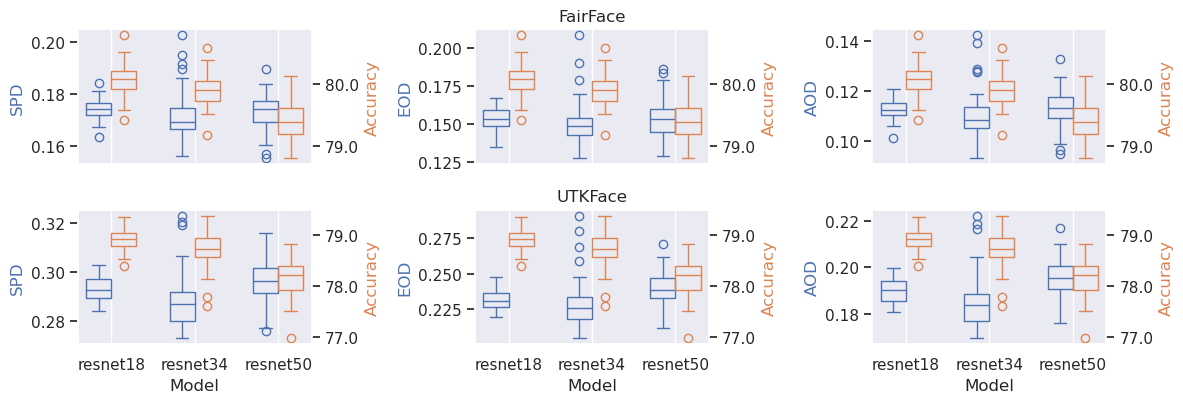

In [139]:
x = list(range(len(models)))
x_fair = [-0.15, 0.85, 1.85]
x_acc = [0.15, 1.15, 2.15]
color = "C0"

bps = list()

acc_axs = list()
f, axs = plt.subplots(2, 3, figsize=(12, 4.2), sharex=True)

bps.append(axs[0, 0].boxplot(ff_test_spds, positions=x_fair, widths=0.3, boxprops=dict(color=color), flierprops=dict(markeredgecolor=color)))
axs[0, 0].set_ylabel("SPD", color=color)
acc_axs.append(axs[0, 0].twinx())
bps.append(axs[0, 1].boxplot(ff_test_eods, positions=x_fair, widths=0.3, boxprops=dict(color=color), flierprops=dict(markeredgecolor=color)))
axs[0, 1].set_ylabel("EOD", color=color)
acc_axs.append(axs[0, 1].twinx())
bps.append(axs[0, 2].boxplot(ff_test_aods, positions=x_fair, widths=0.3, boxprops=dict(color=color), flierprops=dict(markeredgecolor=color)))
axs[0, 2].set_ylabel("AOD", color=color)
acc_axs.append(axs[0, 2].twinx())
bps.append(axs[1, 0].boxplot(utk_test_spds, positions=x_fair, widths=0.3, boxprops=dict(color=color), flierprops=dict(markeredgecolor=color)))
axs[1, 0].set_ylabel("SPD", color=color)
acc_axs.append(axs[1, 0].twinx())
bps.append(axs[1, 1].boxplot(utk_test_eods, positions=x_fair, widths=0.3, boxprops=dict(color=color), flierprops=dict(markeredgecolor=color)))
axs[1, 1].set_ylabel("EOD", color=color)
acc_axs.append(axs[1, 1].twinx())
bps.append(axs[1, 2].boxplot(utk_test_aods, positions=x_fair, widths=0.3, boxprops=dict(color=color), flierprops=dict(markeredgecolor=color)))
axs[1, 2].set_ylabel("AOD", color=color)
acc_axs.append(axs[1, 2].twinx())

axs[0, 1].set_title("FairFace")
axs[1, 1].set_title("UTKFace")

for ax in acc_axs[:3]:
    bp = ax.boxplot(ff_test_accs, positions=x_acc, widths=0.3, boxprops=dict(color="C1"), flierprops=dict(markeredgecolor="C1"))
    plt.setp(bp['whiskers'], color="C1")
    plt.setp(bp['caps'], color="C1")
    plt.setp(bp['medians'], color="C1")
for ax in acc_axs[3:]:
    bp = ax.boxplot(utk_test_accs, positions=x_acc, widths=0.3, boxprops=dict(color="C1"), flierprops=dict(markeredgecolor="C1"))
    plt.setp(bp['whiskers'], color="C1")
    plt.setp(bp['caps'], color="C1")
    plt.setp(bp['medians'], color="C1")

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xticks(x)
    if i >= 3:
        ax.set_xlabel("Model")
    ax.set_xticklabels(models)

for ax in acc_axs:
    
    ax.yaxis.grid(False)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
    ax.set_ylabel("Accuracy", color="C1")
    ax.set_xlim(-0.4, 2.4)

for boxplot in bps:
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=color)
    plt.setp(boxplot['caps'], color=color)
    plt.setp(boxplot['medians'], color=color)

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"compare_models_absolute_target{target}_pa{pa}.pdf"))
plt.show()